# CNN Quick Drew Example - With Pre-Train Model & Transfer Learning
- This notebook show you to load dataset, train mobilenet, test the model and convert to tflite for deployment on nuvoTon target board.
- Please follow the step by step and you could change the parameters for exploring the possibility.  

In [ ]:
%matplotlib inline
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import os
import sys
import ast
import re
import pathlib
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU, GlobalAveragePooling2D 
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
start = dt.datetime.now()

In [2]:
#---------------------------------------------#
# Update parameters basing on your request
#---------------------------------------------#

DP_DIR = './dataset/simplified_small_bitmap' # The shuffled dataset
TIME_COLOR = False

NUM_CATS = 5                                    # The classes number

WORK_DIR = './workspace/5_CNN_finetune'       # The user defined name of work dir
MODEL_NAME = 'CNN_5_finetune'                 # The output model's name

INPUT_IMG_SIZE = 32                               # The size of training input image
BATCHSIZE = 512                                   # For train data generator's batchsize => train data number every 1 epoch = STEPS_P_EPOCH * BATCHSIZE

EPOCHS = 10                                      # How many EPOCHS for 1 training.

MODEL_TYPE = 'cnn'                                # 'cnn', 'ds-cnn'

PRETRAIN_DIR = './pretrain_model/CNN_340_all/'
#---------------------------------------------#

np.random.seed(seed=1987)
#tf.set_random_seed(seed=1987)
def create_dirs(proj_path, model_name): 
    if not os.path.exists(proj_path):
        os.makedirs(proj_path)
        os.makedirs(os.path.join(proj_path, model_name))
        os.makedirs(os.path.join(proj_path, 'tflite'))
        os.makedirs(os.path.join(proj_path, 'checkpoint'))
    else:
        print('Work folder exist!')    
    return proj_path

create_dirs(WORK_DIR, MODEL_NAME)    

Work folder exist!


'./workspace/5_CNN_finetune'

## Create Image Generator for training and the validation dataset

In [3]:

train_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'train'),
                                                            label_mode='categorical', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
validation_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'validation'),
                                                                 label_mode='categorical',
                                                                 shuffle=True,
                                                                 color_mode = 'grayscale',
                                                                 batch_size=BATCHSIZE,
                                                                 image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))

class_names = train_dataset.class_names
print('Class names: {}'.format(class_names))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Found 400000 files belonging to 5 classes.
Found 50000 files belonging to 5 classes.
Class names: ['airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration']
Number of train batches: 782
Number of validation batches: 98


In [4]:
#@tf.autograph.experimental.do_not_convert
#@tf.function
def normalization_data( dataset):
    
    #if not TIME_COLOR:
    #    def no_time_color(x,y): 
    #        return tf.cond((x!=0), lambda: 255, lambda: 255) 
    #    out_dataset = dataset.map(lambda x, y: ((255 if x!=0. else 0), y), num_parallel_calls=tf.data.AUTOTUNE) # Change back to color 255 only

    # normalization for the data, expects pixel values in [0, 1] from [0, 255]
    #normalization_layer =  tf.keras.layers.Rescaling(1./127.5, offset=-1)
    normalization_layer =  tf.keras.layers.Rescaling(1./255.)      
    out_dataset = dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return out_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = normalization_data(train_dataset)
validation_dataset = normalization_data(validation_dataset)

train dataset example:


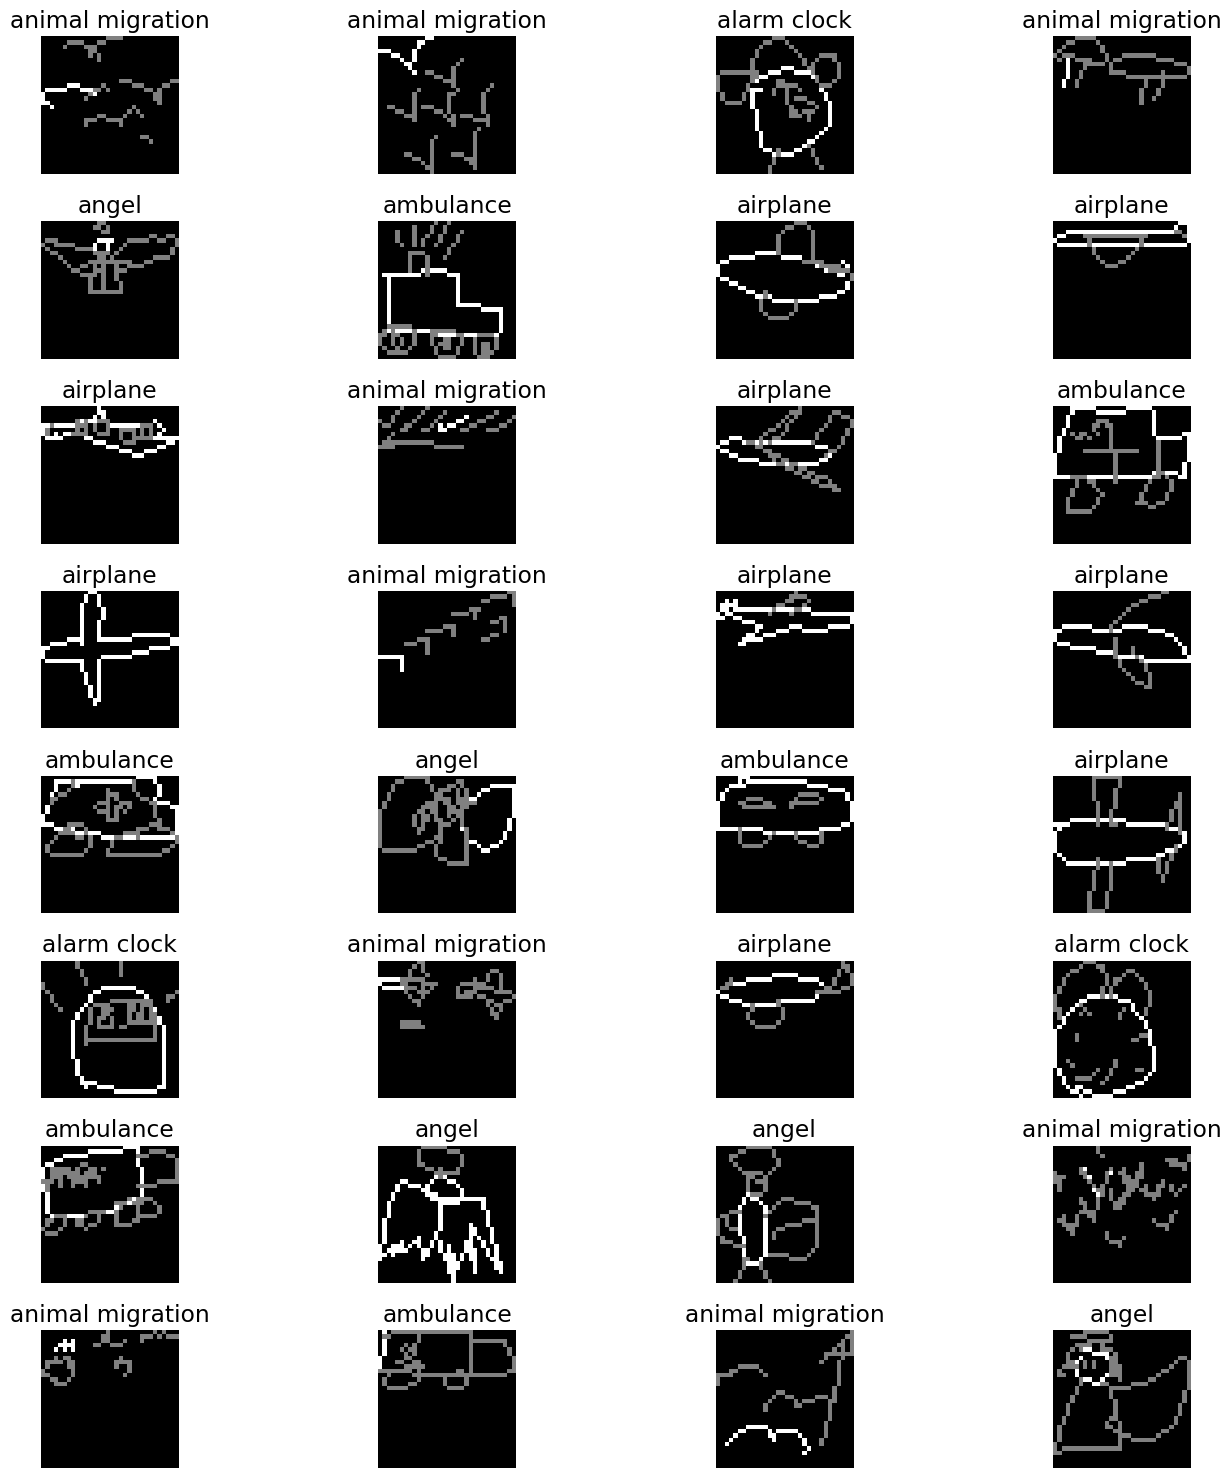

In [9]:
print("train dataset example:")
for images, labels in train_dataset.take(1):
  plt.figure(figsize=(15, 15))
  x = 0
  for im, l in zip(images, labels):
    if x > 31:
          break   
    ax = plt.subplot(8, 4, x + 1)
    x = x +1
    #print(im)
    plt.imshow(im.numpy().astype("int8"), cmap=plt.cm.gray)
    plt.title(class_names[tf.math.argmax(l)])
    plt.axis("off")
  plt.tight_layout()
  plt.show();   

## Start to training

#### Create the model & training

In [12]:
def custom_single_cnn(size, conv_layers=(8, 16, 32, 64), dense_layers=(512, 256), conv_dropout=0.2,
                      dense_dropout=0.2):
    model = Sequential()
    model.add(Conv2D(conv_layers[0], kernel_size=(3, 3), padding='same', activation='relu', input_shape=(size, size, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    if conv_dropout:
        model.add(Dropout(conv_dropout))

    for conv_layer_size in conv_layers[1:]:
        model.add(Conv2D(conv_layer_size, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        if conv_dropout:
            model.add(Dropout(conv_dropout))

    model.add(Flatten())

    for dense_layer_size in dense_layers:
        model.add(Dense(dense_layer_size, activation='relu'))
        model.add(Activation('relu'))
        if dense_dropout:
            model.add(Dropout(dense_dropout))

    model.add(Dense(NUM_CATS, activation='softmax'))
    return model

def load_pretrain_model(md_path):
    # load the keras model and the custom op.
    base_model = keras.models.load_model(md_path, custom_objects={'top_3_accuracy':top_3_accuracy}, compile=False)
    base_model.trainable = False

    print("The total layers number: {}".format(len(base_model.layers)))

    # create the custom model
    inputs = tf.keras.Input(shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 1))
    #x = inputs
    #x = base_model(x, training=False).layers[-2].output
    x = base_model.layers[-2].output
    predictions = Dense(NUM_CATS, activation='softmax',  name='add_dense_1')(x)
    model = tf.keras.Model(base_model.input, predictions)

    return model

def find_best_ckpt(dir_path, model):
      pattern = re.compile(r"\d.\d+")
      max_number = None
      # Iterate over the files in the directory
      for file in dir_path.iterdir():
          filename = file.name
          match = pattern.search(filename)
          if match:
              number_str = match.group()
              number = float(number_str)
              if max_number is None or number > max_number:
                  max_number = number
      if max_number is None:
          print("There is no best ckpt in this work project.")  
      else:
          print("Find the best ckpt:{}".format(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))
          model.load_weights(str(pathlib.Path(dir_path)/(number_str+f'_best_val.ckpt')))      
      
      return model

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [13]:
if MODEL_TYPE.lower() == 'cnn':
    model = custom_single_cnn(size=INPUT_IMG_SIZE,
                          conv_layers=[128, 64],
                          dense_layers=[1024],
                          conv_dropout=False,
                          dense_dropout=0.25)
    
    model = load_pretrain_model(PRETRAIN_DIR)

    model.compile(optimizer=Adam(learning_rate=0.0024), loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_crossentropy, tf.keras.metrics.categorical_accuracy, top_3_accuracy])

# If there is a checkpt, load the previous weights.
if (pathlib.Path(WORK_DIR)/'checkpoint').exists():    
    #print("Previous checkpoint folder found; loading saved weights")
    model = find_best_ckpt((pathlib.Path(WORK_DIR)/'checkpoint'), model)
else:
    print("No checkpoint found, create the workfolder.")
  
print("The trainable layers number: {}".format(len(model.trainable_variables)))
print(model.summary())

The total layers number: 9
There is no best ckpt in this work project.
The trainable layers number: 2
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 32, 32, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                       

In [14]:
callbacks_chpt = tf.keras.callbacks.ModelCheckpoint(
                filepath=(os.path.join(WORK_DIR, 'checkpoint', '{val_categorical_accuracy:.3f}_best_val.ckpt')),
                save_weights_only=True, 
                monitor='val_categorical_accuracy',
                mode = 'max',
                save_best_only=True, 
                save_freq='epoch')

callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', patience=7, min_delta=0.001, mode='max'),
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5, min_delta=0.005, mode='max', cooldown=3),
    callbacks_chpt
]

hist = model.fit(
    train_dataset, epochs=EPOCHS, verbose=1,
    validation_data=validation_dataset,
    callbacks = callbacks
)

Epoch 1/10


782/782 [==============================] - 60s 71ms/step - loss: 3.0854 - categorical_crossentropy: 3.0854 - categorical_accuracy: 0.6145 - top_3_accuracy: 0.9051 - val_loss: 0.8208 - val_categorical_crossentropy: 0.8208 - val_categorical_accuracy: 0.7136 - val_top_3_accuracy: 0.9478 - lr: 0.0024
Epoch 2/10
782/782 [==============================] - 55s 70ms/step - loss: 1.2741 - categorical_crossentropy: 1.2741 - categorical_accuracy: 0.6400 - top_3_accuracy: 0.9169 - val_loss: 0.9463 - val_categorical_crossentropy: 0.9463 - val_categorical_accuracy: 0.6909 - val_top_3_accuracy: 0.9442 - lr: 0.0024
Epoch 3/10
782/782 [==============================] - 55s 69ms/step - loss: 1.4843 - categorical_crossentropy: 1.4843 - categorical_accuracy: 0.6371 - top_3_accuracy: 0.9156 - val_loss: 0.9722 - val_categorical_crossentropy: 0.9722 - val_categorical_accuracy: 0.7427 - val_top_3_accuracy: 0.9433 - lr: 0.0024
Epoch 4/10
782/782 [==============================] - 55s 69ms/step - loss: 1.2198 -

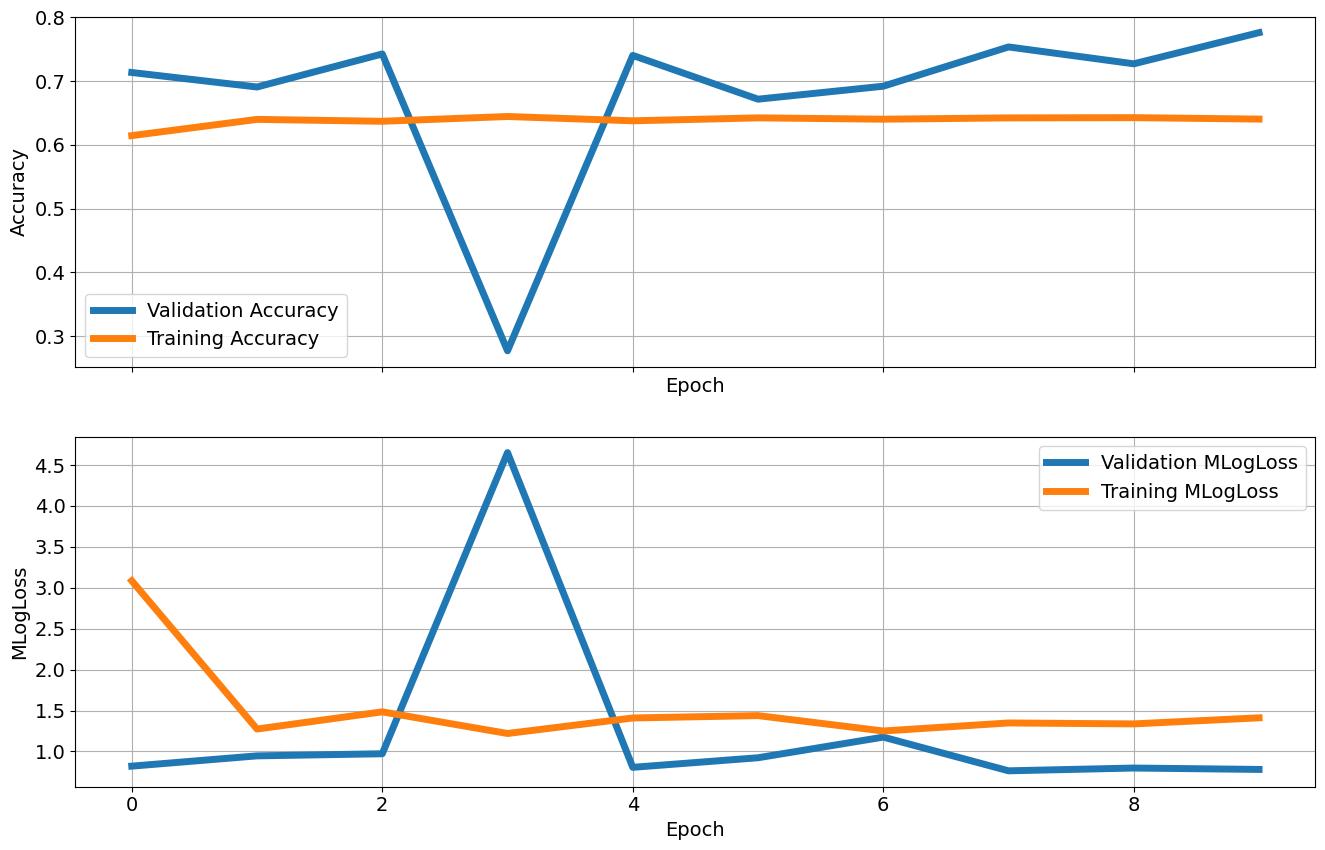

In [15]:
hist_df = pd.DataFrame(hist.history)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig(os.path.join(WORK_DIR, 'hist.png'), dpi=300)
plt.show();

In [32]:
test_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(DP_DIR, 'test'),
                                                            label_mode='categorical', 
                                                            shuffle=True,
                                                            color_mode = 'grayscale',
                                                            batch_size=BATCHSIZE,
                                                            image_size=(INPUT_IMG_SIZE, INPUT_IMG_SIZE))
test_dataset = normalization_data(test_dataset)

Found 50000 files belonging to 5 classes.


In [33]:
loss, crossentropy, top1, top3= model.evaluate(test_dataset)
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))

98/98 [==============================] - 6s 54ms/step - loss: 0.7898 - categorical_crossentropy: 0.7898 - categorical_accuracy: 0.7697 - top_3_accuracy: 0.9545
Top1 Accuracy: 0.770
Top3 Accuracy: 0.955


In [23]:
valid_predictions = model.predict(validation_dataset, batch_size=128, verbose=1)

98/98 [==============================] - 6s 53ms/step


## Save the model

In [26]:
model.save(os.path.join(WORK_DIR, MODEL_NAME))
#tf.keras.models.save_model(model, os.path.join(WORK_DIR, MODEL_NAME))

INFO:tensorflow:Assets written to: ./workspace/5_CNN_finetune\CNN_5_finetune\assets


INFO:tensorflow:Assets written to: ./workspace/5_CNN_finetune\CNN_5_finetune\assets


## Convert to tflite
- Include quantization and offer normal, dynamic quantization, float16 quantization and int8 quantization tflite.

In [21]:
def convert2tflite(custom_model_path, output_tflite_location, rep_batch_num):
      
      def representative_dataset():
        idx = 0
        for images, _ in validation_dataset.take(rep_batch_num):
            idx = 0
            for i in range(BATCHSIZE): 
                idx = idx + 1
                image = tf.expand_dims(images[i], axis=0)
                #image = tf.dtypes.cast(image, tf.float32) 
                yield [image] # total loop is rep_batch_num * BATCHSIZE    
      
      # load the keras model and the custom op.
      custom_model = keras.models.load_model(os.path.join(WORK_DIR, MODEL_NAME), custom_objects={'top_3_accuracy':top_3_accuracy})

      # normal tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # dynamic tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_dyquant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))
      
      # int8 Full tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.TFLITE_BUILTINS]
      converter.representative_dataset = representative_dataset
      converter.inference_input_type = tf.int8  # or tf.uint8
      converter.inference_output_type = tf.int8  # or tf.uint8
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_int8quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location)) 
      
      # f16 tflite
      converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
      converter.optimizations = [tf.lite.Optimize.DEFAULT]
      converter.target_spec.supported_types = [tf.float16]
      #converter.representative_dataset = representative_dataset
      tflite_model = converter.convert()
      output_location = os.path.join(output_tflite_location, (MODEL_NAME + r'_f16quant.tflite'))
      with open(output_location, 'wb') as f:
            f.write(tflite_model)
      print("The tflite output location: {}".format(output_location))

In [22]:
convert2tflite(os.path.join(WORK_DIR, MODEL_NAME), os.path.join(WORK_DIR, 'tflite'), 1)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp24nh8zkn\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmp24nh8zkn\assets


The tflite output location: ./workspace/340_all_CNN_resize\tflite\CNN_340_all.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpxpf6lue1\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpxpf6lue1\assets


The tflite output location: ./workspace/340_all_CNN_resize\tflite\CNN_340_all_dyquant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpx2mvuz3f\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpx2mvuz3f\assets
c:\ProgramData\anaconda3\envs\NuEdgeWise_env\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


The tflite output location: ./workspace/340_all_CNN_resize\tflite\CNN_340_all_int8quant.tflite


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpntw__3mc\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpntw__3mc\assets


The tflite output location: ./workspace/340_all_CNN_resize\tflite\CNN_340_all_f16quant.tflite


## Test the tflite to make sure the accuracy. 

In [23]:
from tqdm import tqdm
def tflite_inference(rep_dataset, rep_dataset_y, tflite_path, batch_N):
      """Call forwards pass of TFLite file and returns the result.
  
      Args:
          input_data: Input data to use on forward pass.
          tflite_path: Path to TFLite file to run.
  
      Returns:
          Output from inference.
      """

      interpreter = tf.lite.Interpreter(model_path=tflite_path)
      
  
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()
  
      input_dtype = input_details[0]["dtype"]
      output_dtype = output_details[0]["dtype"]

      input_shape = input_details[0]['shape']
      output_shape = output_details[0]['shape']
      interpreter.resize_tensor_input(input_details[0]['index'], [batch_N, input_shape[1], input_shape[2], input_shape[3]])
      interpreter.resize_tensor_input(output_details[0]['index'], [batch_N, output_shape[1]])

      interpreter.allocate_tensors()
  
      # Check if the input/output type is quantized,
      # set scale and zero-point accordingly
      if input_dtype == np.int8:
          input_scale, input_zero_point = input_details[0]["quantization"]

          rep_dataset = np.round(rep_dataset/input_scale + input_zero_point)

      else:
          #input_scale, input_zero_point = 1, 0
          input_scale, input_zero_point = input_details[0]["quantization"]
  
      if input_dtype == np.int8:
          output_scale, output_zero_point = output_details[0]["quantization"]
      else:
          output_scale, output_zero_point = 1, 0
      
      # skip the final set < batch_N, bcs the input/output tensor are fix. 
      loop_num = (int)(np.floor(len(rep_dataset)/batch_N))  
      
      acy_all  = 0
      acy_top3 = 0
      for i in tqdm(range(loop_num)):
          #if i == (loop_num - 1):
          #    input_batch = rep_dataset[i*batch_N:-1]
          #else:
          input_batch = rep_dataset[i*batch_N:(i+1)*batch_N]

          interpreter.set_tensor(input_details[0]['index'], tf.cast(input_batch, input_dtype))
          interpreter.invoke()
          output_data = interpreter.get_tensor(output_details[0]['index'])
          output_data = output_scale * (output_data.astype(np.float32) - output_zero_point)
          #print(preds2catIdx(output_data).shape)
          acy_all += top1_acc(valid_df[['y']][i*batch_N:(i+1)*batch_N].values.flatten(), preds2catIdx(output_data).values)
          acy_top3 += top3_acc(rep_dataset_y[['y']][i*batch_N:(i+1)*batch_N].values.flatten(), preds2catIdx(output_data).values)
          #print('Top3 Accuracy: {:.3f}'.format(top3))

      return   acy_all/loop_num, acy_top3/loop_num

      

      
    


In [24]:
top1, top3 = tflite_inference(x_valid[0:5000], valid_df[['y']][0:5000], os.path.join(WORK_DIR, 'tflite', (MODEL_NAME + r'_int8quant.tflite')), 512) 

100%|██████████| 9/9 [04:52<00:00, 32.49s/it]


In [25]:
print('Top1 Accuracy: {:.3f}'.format(top1))
print('Top3 Accuracy: {:.3f}'.format(top3))  

Top1 Accuracy: 0.690
Top3 Accuracy: 0.854
